# Explore the Data for Kaggle Parkinson's Prediction

https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_rows', None)

In [32]:
train_clin_df = pd.read_csv('../data/raw/train_clinical_data.csv')
train_prot_df = pd.read_csv('../data/raw/train_proteins.csv')
train_pep_df = pd.read_csv('../data/raw/train_peptides.csv')

test_df = pd.read_csv('../data/raw/test.csv')
test_prot_df = pd.read_csv('../data/raw/test_proteins.csv')
test_pep_df = pd.read_csv('../data/raw/test_peptides.csv')

sample_submission = pd.read_csv('../data/raw/sample_submission.csv')

In [33]:
test_df.head()

,visit_id,visit_month,patient_id,updrs_test,row_id,group_key
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0


In [34]:
test_prot_df.head()

,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


In [35]:
test_prot_df['visit_month'].value_counts()

0    227
6    226
Name: visit_month, dtype: int64

In [36]:
test_prot_df.groupby(['patient_id'])['visit_month'].unique()

patient_id
3342     [6]
50423    [0]
Name: visit_month, dtype: object

### Test Protein Data

There is only one visit month per patient in this test_df. As well, that visit month is not always 0. Something to be thoughtful of in creating the training set.

In [37]:
test_pep_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


In [38]:
test_pep_df['visit_month'].value_counts()

6    1036
0    1021
Name: visit_month, dtype: int64

In [39]:
test_prot_df.groupby(['patient_id'])['visit_month'].unique()

patient_id
3342     [6]
50423    [0]
Name: visit_month, dtype: object

### Test Peptide Data

There is only one month per patient in the peptide data which corresponds with the protein data which makes sense.

In [40]:
sample_submission.shape

(64, 3)

In [41]:
sample_submission

,prediction_id,rating,group_key
0,3342_0_updrs_1_plus_0_months,0,0
1,3342_0_updrs_1_plus_6_months,0,0
2,3342_0_updrs_1_plus_12_months,0,0
3,3342_0_updrs_1_plus_24_months,0,0
4,3342_0_updrs_2_plus_0_months,0,0
5,3342_0_updrs_2_plus_6_months,0,0
6,3342_0_updrs_2_plus_12_months,0,0
7,3342_0_updrs_2_plus_24_months,0,0
8,3342_0_updrs_3_plus_0_months,0,0
9,3342_0_updrs_3_plus_6_months,0,0


### Description of the sample submission:
- prediction_id: the row id, updrs number, and the number of months later predicting
- rating: the prediction value of the updrs
- group_key: looks to be the last number of the row id, which is the visit month

#### The sample submission is requesting predictions on row id 3342_0 which does not have any protein data associated with it. That is very surprising.

## Training Data

In [42]:
train_clin_df.head(20)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
5,55_18,55,18,7.0,13.0,38.0,0.0,On
6,55_24,55,24,16.0,9.0,49.0,0.0,On
7,55_30,55,30,14.0,13.0,49.0,0.0,On
8,55_36,55,36,17.0,18.0,51.0,0.0,On
9,55_42,55,42,12.0,20.0,41.0,0.0,On


In [43]:
train_clin_df['upd23b_clinical_state_on_medication'].value_counts()

On     775
Off    513
Name: upd23b_clinical_state_on_medication, dtype: int64

In [44]:
train_clin_df['upd23b_clinical_state_on_medication'].isna().sum() / train_clin_df.shape[0]

0.5074569789674952

### Upd23b medication

There are 50% of the samples have NaN for the medication. This feature may be something to exclude.

In [45]:
train_clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].isna().sum() / train_clin_df.shape[0]

updrs_1    0.000382
updrs_2    0.000765
updrs_3    0.009560
updrs_4    0.396941
dtype: float64

### UPDRs NaN values

UPDRs 4 has 40% missing values.

- Can these values be imputed from anothe updrs that is highly correlated?

In [46]:
train_clin_df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].corr()

,updrs_1,updrs_2,updrs_3,updrs_4
updrs_1,1.000000,0.661802,0.434569,0.432620
updrs_2,0.661802,1.000000,0.735106,0.383866
updrs_3,0.434569,0.735106,1.000000,0.221593
updrs_4,0.432620,0.383866,0.221593,1.000000


### No Major UPDR 4 correlation

Based on simple correlation there is no way to impute the missing values

## Use ML to impute the UPDRs 4 missing values

In [47]:
rf_imputer = RandomForestRegressor()


train_data = train_clin_df.dropna()

# drop the null value rows of updrs_1, 2, 3 since it is needed for imputing
to_impute_data = train_clin_df.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3'])
to_impute_data = to_impute_data[to_impute_data['updrs_4'].isna()]

impute_trainer = train_data[train_data['updrs_4'].notnull()]

rf_imputer.fit(impute_trainer[['updrs_1', 'updrs_2', 'updrs_3']], impute_trainer[['updrs_4']])

impute_values = rf_imputer.predict(to_impute_data[['updrs_1', 'updrs_2', 'updrs_3']])

to_impute_data['updrs_4'] = [round(x) for x in impute_values]

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


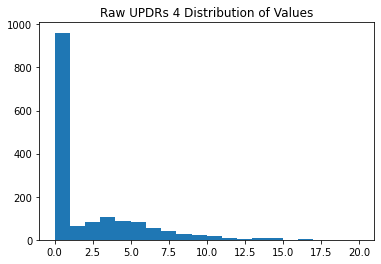

In [48]:
plt.hist(train_clin_df['updrs_4'], bins=20)
plt.title('Raw UPDRs 4 Distribution of Values')
plt.show()

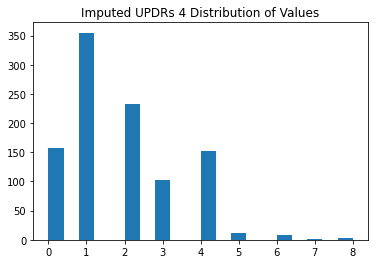

In [49]:
plt.hist(to_impute_data['updrs_4'], bins=20)
plt.title('Imputed UPDRs 4 Distribution of Values')
plt.show()

## Imputed UPDRs 4

The imputed values of UPDRs 4 are mostly between 0 and 2 but has far too many 1 values compared to the raw updrs. It may be better to look if there is a protein expressed that correlates highly with the non zero values.

In [50]:
# create a column with the UniProt and Peptide name combined
train_pep_df['peptide_uniprot'] = train_pep_df['Peptide'] + '_'+ train_pep_df['UniProt']
train_pep_df.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,peptide_uniprot
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,NEQEQPLGQWHLS_O00391
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,GNPEPTFSWTK_O00533
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,IEIPSSVQQVPTIIK_O00533
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK_O00533
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,SMEQNGPGLEYR_O00533


In [51]:
# create a table with the visit_id as the index and the proteins or peptides as the feature and the abundance as the values
train_prot_pivot = train_prot_df.pivot(index='visit_id', values='NPX', columns='UniProt')
train_pep_pivot = train_pep_df.pivot(index='visit_id', values='PeptideAbundance', columns='peptide_uniprot')

In [52]:
# combine the two tables on the visit_id
full_prot_train_df = train_prot_pivot.join(train_pep_pivot)
full_prot_train_df = full_prot_train_df.reset_index(drop=True)
full_prot_train_df.head()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,129048.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,108114.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,163776.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,56725.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,85767.1,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [53]:
# fill nan with 0 for this first round
full_prot_train_df = full_prot_train_df.fillna(0)

In [54]:
train_prot_pivot = train_prot_pivot.reset_index()

train_prot_pivot.head()

UniProt,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,557904.0,44556.90,155619.0,14647.9,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,NaN,47836.70,177619.0,17061.1,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55


In [55]:
train_prot_pivot = train_prot_pivot.fillna(0)

# merge the protein data and the clinical data
train_clin_prot = train_clin_df.merge(train_prot_pivot, on='visit_id', how='left')

In [56]:
train_clin_prot.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7
3,55_9,55,9,8.0,9.0,30.0,0.0,On,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,303953.0,43026.2,114921.0,21860.1,61598.2,318553.0,65762.6,29193.4,28536.1,19290.9


In [57]:
# look for a correlation between the updrs_4 and the proteins
updrs_4_corr = train_clin_prot.corr()['updrs_4'].sort_values(ascending=False)
updrs_4_corr[:20]

updrs_4        1.000000
updrs_1        0.432620
updrs_2        0.383866
updrs_3        0.221593
visit_month    0.138013
P23083         0.124741
P31997         0.102361
P43251         0.089153
P16152         0.087579
P19827         0.082150
P01594         0.078567
P04275         0.076342
P55290         0.071613
P14314         0.071270
Q7Z5P9         0.062275
Q9UNU6         0.061301
Q6UX71         0.050691
O75144         0.050257
O94919         0.046582
O00391         0.045957
Name: updrs_4, dtype: float64

In [65]:
def imputer_updrs(val):
    if val == 0:
        return 0
    elif val > 0:
        return 1
    else:
        return np.nan

In [66]:
# can the updrs_4 be classified as 0 or greater than 0 
train_clin_prot['updrs_4_value_0'] = train_clin_prot['updrs_4'].apply(imputer_updrs)

In [67]:
# look for a correlation between the updrs_4_value_0 and the proteins
updrs_4_cat_corr = train_clin_prot.corr()['updrs_4_value_0'].sort_values(ascending=False)
updrs_4_cat_corr[:20]

updrs_4_value_0    1.000000
updrs_4            0.769702
updrs_1            0.336749
updrs_2            0.324829
visit_month        0.239479
updrs_3            0.219840
P43251             0.110328
P02655             0.077979
P19827             0.073717
P31997             0.071600
P04275             0.066442
P02765             0.065464
P11277             0.058547
P23083             0.054157
P55290             0.050317
Q7Z5P9             0.045373
P16152             0.039239
P04004             0.031860
Q9UNU6             0.030273
P02766             0.029575
Name: updrs_4_value_0, dtype: float64

In [68]:
# train a random forest classifier to predict the updrs_4_value_0
rf_clf = RandomForestClassifier()

# drop nan values for updrs_4
train_impute_prot = train_clin_prot.dropna(subset=['updrs_4', 'updrs_1', 'updrs_2', 'updrs_3'])
train_impute_prot = train_impute_prot.fillna(0)
train_impute_df  = train_impute_prot.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication'])
train_cols = train_impute_df.columns


# train the classifier
rf_clf.fit(train_impute_prot.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication']), train_impute_prot['updrs_4_value_0'])

RandomForestClassifier()

In [69]:
impute_df = train_clin_prot.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3'])
impute_df = impute_df[impute_df['updrs_4'].isna()]

impute_X = impute_df.drop(columns=['patient_id', 'visit_id', 'upd23b_clinical_state_on_medication', 'updrs_4', 'updrs_4_value_0'])
fill_cols = [x for x in train_cols if x not in impute_X.columns]
fill_df = pd.DataFrame(columns=fill_cols)
impute_X = pd.concat([impute_X, fill_df], axis=1)
impute_X = impute_X.fillna(0)

impute_values = rf_clf.predict(impute_X[train_cols])

In [70]:
impute_df['updrs_4_pred'] = impute_values
impute_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7,updrs_4_value_0,updrs_4_pred
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5,NaN,0.0
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7,NaN,0.0
13,942_0,942,0,3.0,2.0,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14,942_3,942,3,7.0,2.0,17.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [72]:
impute_df['updrs_4_pred'].value_counts()

0.0    1026
Name: updrs_4_pred, dtype: int64

#### For updrs_1, updrs_2, and updrs_3 all null rows can be dropped since they are a small amount totaling about 1% of the rows.

#### Also the first round of predictions will be on only updrs_1, updrs_2, and updrs_3 only, so updrs_4 can be dropped completely

In [60]:
train_clin_df = train_clin_df.iloc[:, :6]
train_clin_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3
0,55_0,55,0,10.0,6.0,15.0
1,55_3,55,3,10.0,7.0,25.0
2,55_6,55,6,8.0,10.0,34.0
3,55_9,55,9,8.0,9.0,30.0
4,55_12,55,12,10.0,10.0,41.0


In [61]:
train_clin_df = train_clin_df.dropna()
train_clin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2588 entries, 0 to 2614
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   visit_id     2588 non-null   object 
 1   patient_id   2588 non-null   int64  
 2   visit_month  2588 non-null   int64  
 3   updrs_1      2588 non-null   float64
 4   updrs_2      2588 non-null   float64
 5   updrs_3      2588 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 141.5+ KB


In [62]:
full_train_df = train_clin_df.merge(full_prot_train_df, how='right', left_on='visit_id', right_on='visit_id')
full_train_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,10053_0,10053.0,0.0,3.0,0.0,13.0,9104.27,402321.0,0.00,0.0,...,202274.0,0.00,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,0.0,7207.30
1,10053_12,10053.0,12.0,4.0,2.0,8.0,10464.20,435586.0,0.00,0.0,...,201009.0,0.00,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,10053.0,18.0,2.0,2.0,0.0,13235.70,507386.0,7126.96,24525.7,...,220728.0,0.00,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,10138.0,12.0,3.0,6.0,31.0,12600.20,494581.0,9165.06,27193.5,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,10138.0,24.0,4.0,7.0,19.0,12003.20,522138.0,4498.51,17189.8,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,0.0,56977.6,4903.09


### Use the right join to eliminate any clinic visits that did not have the protein and peptides taken

### Try Random Forrest Regressor to start on updrs_1 only

target column will be updrs_1 and training data will be all the peptide and protein data.

visit_month, patient_id, and visit_month will all be excluded

In [63]:
# view the first target value counts
full_train_df['updrs_1'].value_counts()

1.0     117
2.0     105
5.0      89
6.0      88
4.0      78
3.0      77
7.0      67
8.0      64
0.0      61
9.0      57
11.0     42
10.0     41
12.0     32
14.0     24
13.0     21
16.0     17
15.0     15
20.0     13
17.0     12
18.0     11
19.0      9
25.0      5
21.0      3
23.0      2
26.0      2
22.0      2
24.0      1
27.0      1
28.0      1
33.0      1
Name: updrs_1, dtype: int64

#### Perform KFold Cross Validation on the Data for the Model

In [64]:
# randomize the rows
full_train_df = full_train_df.sample(frac=1).reset_index(drop=True)
full_train_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,O00391,O00533,O00584,O14498,...,YSLTYIYTGLSK_P25311,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675
0,29313_6,29313.0,6.0,6.0,1.0,17.0,12091.20,290090.0,25652.60,31288.9,...,209437.0,9781.47,2892880.0,118819.0,1684560.0,108770.0,119872.0,613070.0,49975.7,24248.0
1,49239_36,49239.0,36.0,11.0,11.0,26.0,13589.70,1064420.0,63575.50,46719.6,...,166223.0,18378.40,2676020.0,60879.9,295033.0,116742.0,114126.0,339034.0,69195.0,0.0
2,42385_24,42385.0,24.0,3.0,0.0,0.0,8769.71,591324.0,9298.51,27472.4,...,184732.0,7151.46,2621040.0,19424.4,125889.0,108429.0,112764.0,372088.0,43826.1,20697.1
3,47881_0,47881.0,0.0,1.0,2.0,14.0,11369.40,233674.0,23339.50,19255.9,...,280227.0,4318.67,6144270.0,73488.0,845429.0,64338.3,123588.0,441960.0,36632.6,23155.5
4,26210_24,26210.0,24.0,5.0,4.0,5.0,10723.20,529157.0,28389.00,23860.8,...,227976.0,8347.46,2581610.0,0.0,168330.0,157205.0,134560.0,357203.0,38156.7,14699.0


In [65]:
full_train_df.shape

(1113, 1201)

In [66]:
full_train_df['updrs_1'].isna().sum()

55

In [67]:
# calculate the number of bins by Sturge's rule
num_bins = int(np.floor(1 + np.log2(len(full_train_df))))
print(num_bins)

11


In [68]:
# bin the target updrs_1
full_train_df.loc[:, "bins"] = pd.cut(full_train_df['updrs_1'], bins=num_bins, labels=False)
full_train_df['bins'].head()

0    1.0
1    3.0
2    0.0
3    0.0
4    1.0
Name: bins, dtype: float64

In [69]:
full_train_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,O00391,O00533,O00584,O14498,...,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675,bins
0,29313_6,29313.0,6.0,6.0,1.0,17.0,12091.20,290090.0,25652.60,31288.9,...,9781.47,2892880.0,118819.0,1684560.0,108770.0,119872.0,613070.0,49975.7,24248.0,1.0
1,49239_36,49239.0,36.0,11.0,11.0,26.0,13589.70,1064420.0,63575.50,46719.6,...,18378.40,2676020.0,60879.9,295033.0,116742.0,114126.0,339034.0,69195.0,0.0,3.0
2,42385_24,42385.0,24.0,3.0,0.0,0.0,8769.71,591324.0,9298.51,27472.4,...,7151.46,2621040.0,19424.4,125889.0,108429.0,112764.0,372088.0,43826.1,20697.1,0.0
3,47881_0,47881.0,0.0,1.0,2.0,14.0,11369.40,233674.0,23339.50,19255.9,...,4318.67,6144270.0,73488.0,845429.0,64338.3,123588.0,441960.0,36632.6,23155.5,0.0
4,26210_24,26210.0,24.0,5.0,4.0,5.0,10723.20,529157.0,28389.00,23860.8,...,8347.46,2581610.0,0.0,168330.0,157205.0,134560.0,357203.0,38156.7,14699.0,1.0


In [70]:
# drop the NaN rows
full_train_df = full_train_df.dropna().reset_index(drop=True)
full_train_df.shape

(1058, 1202)

In [71]:
# initiate the kfold class from sklearn
kf = StratifiedKFold(n_splits=5)

In [72]:
# create a kfold column
full_train_df['kfold'] = -1

# fill the kfold column
for f, (t_, v_) in enumerate(kf.split(X=full_train_df, y=full_train_df['bins'].values)):
    full_train_df.loc[v_, 'kfold'] = f

C:\Users\Dagart\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [73]:
# drop the bins column
full_train_df = full_train_df.drop('bins', axis=1)


In [74]:
full_train_df.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,O00391,O00533,O00584,O14498,...,YTTEIIK_P00736,YVGGQEHFAHLLILR_P02763,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR_P00738,YVMLPVADQDQC(UniMod_4)IR_P00738,YVNKEIQNAVNGVK_P10909,YWGVASFLQK_P02753,YYC(UniMod_4)FQGNQFLR_P02790,YYTYLIMNK_P01024,YYWGGQYTWDMAK_P02675,kfold
0,29313_6,29313.0,6.0,6.0,1.0,17.0,12091.20,290090.0,25652.60,31288.9,...,9781.47,2892880.0,118819.0,1684560.0,108770.0,119872.0,613070.0,49975.7,24248.0,0
1,49239_36,49239.0,36.0,11.0,11.0,26.0,13589.70,1064420.0,63575.50,46719.6,...,18378.40,2676020.0,60879.9,295033.0,116742.0,114126.0,339034.0,69195.0,0.0,0
2,42385_24,42385.0,24.0,3.0,0.0,0.0,8769.71,591324.0,9298.51,27472.4,...,7151.46,2621040.0,19424.4,125889.0,108429.0,112764.0,372088.0,43826.1,20697.1,0
3,47881_0,47881.0,0.0,1.0,2.0,14.0,11369.40,233674.0,23339.50,19255.9,...,4318.67,6144270.0,73488.0,845429.0,64338.3,123588.0,441960.0,36632.6,23155.5,0
4,26210_24,26210.0,24.0,5.0,4.0,5.0,10723.20,529157.0,28389.00,23860.8,...,8347.46,2581610.0,0.0,168330.0,157205.0,134560.0,357203.0,38156.7,14699.0,0


In [75]:
full_train_df.shape

(1058, 1202)

In [76]:
train_csv_df = full_train_df.drop(columns=['kfold'])
train_csv_df.to_csv('../data/processed/train_data.csv', index=False)

In [91]:
def calculate_smape(y_true, y_pred):

    return round(np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100, 2)

In [92]:
def rf_cv_model(df, target, first_month=None):
    
    final_smape = list()
    
    for fold in df['kfold'].unique():
        print(f'Target: {target}')
        print(f'Fold: {fold}')
        kfold = fold
        
        if first_month:
            val_df = df[(df['kfold'] == kfold)&(df['visit_month'] == 0)].reset_index(drop=True)
        else:
            val_df = df[df['kfold'] == kfold].reset_index(drop=True)
        train_df = df[df['kfold'] != kfold].reset_index(drop=True)
        
        updr_list = ['updrs_1', 'updrs_2', 'updrs_3']
        drop_list = ['visit_id', 'patient_id'] + updr_list
    
        y_train = train_df[[target]]
        X_train = train_df.drop(drop_list, axis=1)
        y_val = val_df[[target]]
        X_val = val_df.drop(drop_list, axis=1)

        rf = RandomForestRegressor()

        rf.fit(X_train.values, y_train.values.ravel()) 

        val_preds = rf.predict(X_val.values)
        smape = calculate_smape(y_val.values.ravel(), val_preds)
        r2 = r2_score(y_val.values.ravel(), val_preds)
        
        print(f'SMAPE: {smape}')
        print(f'R-squared: {r2}\n')
        
        final_smape.append(smape)
        
    print('Average SMAPE:', np.mean(final_smape))

In [93]:
for updr in ['updrs_1', 'updrs_2', 'updrs_3']:
    rf_cv_model(full_train_df, updr, first_month=True)

Target: updrs_1
Fold: 0
SMAPE: 59.03
R-squared: 0.1483399319583245

Target: updrs_1
Fold: 1
SMAPE: 85.0
R-squared: 0.17735647604450722

Target: updrs_1
Fold: 2
SMAPE: 54.54
R-squared: 0.3247943282381335

Target: updrs_1
Fold: 3
SMAPE: 81.2
R-squared: -0.17919251706873007

Target: updrs_1
Fold: 4
SMAPE: 80.8
R-squared: -0.1427500120094154

Average SMAPE: 72.114
Target: updrs_2
Fold: 0
SMAPE: 107.93
R-squared: 0.012378721487366517

Target: updrs_2
Fold: 1
SMAPE: 100.39
R-squared: -0.3848605529536182

Target: updrs_2
Fold: 2
SMAPE: 83.06
R-squared: 0.3608483970577159

Target: updrs_2
Fold: 3
SMAPE: 90.59
R-squared: -0.31449615177183476

Target: updrs_2
Fold: 4
SMAPE: 118.49
R-squared: -0.3898578699253976

Average SMAPE: 100.09200000000001
Target: updrs_3
Fold: 0
SMAPE: 92.36
R-squared: 0.06780675425990546

Target: updrs_3
Fold: 1
SMAPE: 78.5
R-squared: 0.04967487358536016

Target: updrs_3
Fold: 2
SMAPE: 75.08
R-squared: 0.34573776876224116

Target: updrs_3
Fold: 3
SMAPE: 76.32
R-squared: 

### Try XGBoost Regressor

In [96]:

import xgboost

def xgboost_cv_model(df, target, first_month=None):

    final_smape = list()

    for fold in df['kfold'].unique():
        print(f'Target: {target}')
        print(f'Fold: {fold}')
        kfold = fold
        
        if first_month:
            val_df = df[(df['kfold'] == kfold)&(df['visit_month'] == 0)].reset_index(drop=True)
        else:
            val_df = df[df['kfold'] == kfold].reset_index(drop=True)
        train_df = df[df['kfold'] != kfold].reset_index(drop=True)
        
        updr_list = ['updrs_1', 'updrs_2', 'updrs_3']
        drop_list = ['visit_id', 'patient_id'] + updr_list
    
        y_train = train_df[[target]]
        X_train = train_df.drop(drop_list, axis=1)
        y_val = val_df[[target]]
        X_val = val_df.drop(drop_list, axis=1)

        xgb = xgboost.XGBRegressor()

        xgb.fit(X_train.values, y_train.values.ravel()) 

        val_preds = xgb.predict(X_val.values)
        smape = calculate_smape(y_val.values.ravel(), val_preds)
    
        print(f'SMAPE: {smape}\n')
        
        final_smape.append(smape)
        
    print('Average SMAPE:', np.mean(final_smape))

In [97]:
for updr in ['updrs_1', 'updrs_2', 'updrs_3']:
    xgboost_cv_model(full_train_df, updr, first_month=True)

Target: updrs_1
Fold: 0
SMAPE: 62.39

Target: updrs_1
Fold: 1
SMAPE: 84.8

Target: updrs_1
Fold: 2
SMAPE: 51.77

Target: updrs_1
Fold: 3
SMAPE: 80.59

Target: updrs_1
Fold: 4
SMAPE: 79.56

Average SMAPE: 71.822
Target: updrs_2
Fold: 0
SMAPE: 105.77

Target: updrs_2
Fold: 1
SMAPE: 102.64

Target: updrs_2
Fold: 2
SMAPE: 88.58

Target: updrs_2
Fold: 3
SMAPE: 93.43

Target: updrs_2
Fold: 4
SMAPE: 123.02

Average SMAPE: 102.68800000000002
Target: updrs_3
Fold: 0
SMAPE: 89.73

Target: updrs_3
Fold: 1
SMAPE: 82.22

Target: updrs_3
Fold: 2
SMAPE: 59.52

Target: updrs_3
Fold: 3
SMAPE: 72.96

Target: updrs_3
Fold: 4
SMAPE: 98.3

Average SMAPE: 80.546
